In [1]:
# This code works in Python 3.10.6
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
import torch_geometric.transforms as T
from torch_geometric.datasets import IMDB
from torch_geometric.nn import HANConv
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import os
import os.path as osp

Read IMDB dataset

In [3]:
dataset = IMDB(root='./imdb_data')
data = dataset[0]
data

Extracting imdb_data/raw/IMDB_processed.zip
Processing...
Done!


HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278]
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)

In [4]:
data['movie'].x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [5]:
torch.unique(data['movie'].x)

tensor([0., 1., 2., 3., 4., 5.])

In [6]:
data['director'].x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [7]:
torch.unique(data['director'].x)

tensor([0.0000, 0.0455, 0.0556, 0.0625, 0.0714, 0.0769, 0.0833, 0.0909, 0.1000,
        0.1111, 0.1250, 0.1364, 0.1429, 0.1538, 0.1667, 0.1818, 0.1875, 0.2000,
        0.2143, 0.2222, 0.2308, 0.2500, 0.2727, 0.2857, 0.3000, 0.3333, 0.3750,
        0.4000, 0.4167, 0.4286, 0.4444, 0.4545, 0.5000, 0.5714, 0.6000, 0.6250,
        0.6667, 0.7143, 0.7500, 0.8000, 0.8571, 1.0000, 1.2500, 1.3333, 1.5000,
        2.0000, 3.0000, 4.0000, 5.0000])

In [8]:
data['actor'].x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [9]:
torch.unique(data['actor'].x)

tensor([0.0000, 0.0192, 0.0222, 0.0250, 0.0286, 0.0294, 0.0312, 0.0323, 0.0333,
        0.0345, 0.0357, 0.0370, 0.0385, 0.0400, 0.0417, 0.0435, 0.0444, 0.0455,
        0.0476, 0.0500, 0.0526, 0.0556, 0.0571, 0.0577, 0.0588, 0.0625, 0.0645,
        0.0667, 0.0690, 0.0714, 0.0741, 0.0750, 0.0769, 0.0800, 0.0833, 0.0857,
        0.0870, 0.0882, 0.0889, 0.0909, 0.0938, 0.0952, 0.0962, 0.0968, 0.1000,
        0.1034, 0.1053, 0.1071, 0.1111, 0.1143, 0.1154, 0.1176, 0.1200, 0.1250,
        0.1290, 0.1304, 0.1333, 0.1364, 0.1379, 0.1429, 0.1471, 0.1481, 0.1500,
        0.1538, 0.1562, 0.1579, 0.1600, 0.1667, 0.1739, 0.1765, 0.1818, 0.1875,
        0.1905, 0.1923, 0.1935, 0.2000, 0.2059, 0.2105, 0.2143, 0.2174, 0.2222,
        0.2308, 0.2353, 0.2381, 0.2500, 0.2609, 0.2632, 0.2667, 0.2727, 0.2778,
        0.2800, 0.2857, 0.3000, 0.3077, 0.3125, 0.3182, 0.3333, 0.3571, 0.3636,
        0.3684, 0.3750, 0.4000, 0.4286, 0.4444, 0.4545, 0.5000, 0.5556, 0.5714,
        0.6000, 0.6250, 0.6667, 0.7143, 

Training data for GMM 

In [10]:
#Original movie node features
movie = data['movie'].x.tolist()
movie_df = pd.DataFrame(movie)
movie_df['class'] = data['movie'].y.tolist()
movie_df

,0,1,2,3,4,5,6,7,8,9,...,3057,3058,3059,3060,3061,3062,3063,3064,3065,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


Fit GMM to 3 movie types

In [11]:
movie_class0 = movie_df[movie_df['class'] == 0].drop(['class'], axis = 1)
movie_class0

,0,1,2,3,4,5,6,7,8,9,...,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
np.unique(movie_class0)

array([0., 1., 2., 3., 4., 5.])

In [13]:
movie_class1 = movie_df[movie_df['class'] == 1].drop(['class'], axis = 1)

In [14]:
np.unique(movie_class1)

array([0., 1., 2., 3., 4., 5.])

In [15]:
movie_class2 = movie_df[movie_df['class'] == 2].drop(['class'], axis = 1)

In [16]:
np.unique(movie_class2)

array([0., 1., 2., 3., 4.])

In [17]:
#Original director node features
director = data['director'].x.tolist()
director_df = pd.DataFrame(director)
director_df

,0,1,2,3,4,5,6,7,8,9,...,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#Original actor node features
actor = data['actor'].x.tolist()
actor_df = pd.DataFrame(actor)
actor_df

,0,1,2,3,4,5,6,7,8,9,...,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Fit and sample GMM

In [19]:
new_features_dict = {}

In [20]:
def sample_features(model,node_type, n_samples):

    smpls = model.sample(n_samples)
    print("no of class {} node samples - {}".format(node_type, n_samples))
    return smpls[0]

In [21]:
def fit_sample_gm(df_class, node_type, n_samples):
    #fit
    model = GaussianMixture(n_components=1, covariance_type='full', random_state = 0)
    model.fit(df_class)
    #print("Mean for nodetype", node_type,model.means_)
    #sample
    smpls = sample_features(model, node_type, n_samples)
    new_features_dict[node_type] = smpls

Classes

0 - director, 1 - actor, 2 - movie

In [22]:
G = nx.read_gexf("IMDB_movie_hgen.gexf")
n_samples_movie = len(dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 2))
n_samples_director = len(dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 0))
n_samples_actor = len(dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 1))

In [23]:
len(dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 2))

726

In [24]:
fit_sample_gm(movie_class0, 'movie0', 242)

no of class movie0 node samples - 242


In [25]:
fit_sample_gm(movie_class1, 'movie1', 242)

no of class movie1 node samples - 242


In [26]:
fit_sample_gm(movie_class2, 'movie2', 242)

no of class movie2 node samples - 242


In [27]:
fit_sample_gm(director_df, 'director', n_samples_director)

no of class director node samples - 410


In [28]:
fit_sample_gm(actor_df, 'actor', n_samples_actor)

no of class actor node samples - 494


Plot node feature distributions

In [29]:
new_features_dict

{'movie0': array([[-2.39982953e-02, -4.12961533e-04, -5.81641234e-04, ...,
          6.38010587e-02,  9.51187915e-03,  1.01832304e-02],
        [-5.18911583e-02, -4.25306076e-04, -3.79639311e-04, ...,
          8.12804838e-02, -2.54378241e-03,  5.13079021e-02],
        [-5.49672742e-02,  3.82492366e-04, -7.22420640e-04, ...,
          1.80858363e-01,  2.45542772e-02,  7.58112991e-02],
        ...,
        [-2.15109289e-02,  1.09522893e-04, -6.40651529e-04, ...,
         -5.77882880e-02,  1.76043880e-03, -2.32128907e-02],
        [-1.57966314e-02, -4.05496497e-04, -1.00773913e-03, ...,
          1.30035681e-01,  3.10171067e-02,  3.26415586e-02],
        [-3.18832476e-02, -1.38368874e-03,  6.45815667e-04, ...,
         -4.47705095e-02,  1.29354969e-02, -3.03677970e-02]]),
 'movie1': array([[-1.47353665e-04, -8.86614260e-04,  5.47770098e-02, ...,
          1.54666223e-01,  1.37860390e-01,  1.62950004e-03],
        [ 4.40000838e-04,  5.76467637e-04, -3.16631124e-03, ...,
         -4.126107

In [30]:
def plot_dist(node_list0,node_list1,node_list2):    

    fig, ax = plt.subplots(figsize=(7, 5))

    sns.distplot(node_list0, label='movie 0', ax=ax , hist= False)
    sns.distplot(node_list1, label='movie 1', ax=ax , hist= False)
    sns.distplot(node_list2, label='movie 2', ax=ax , hist= False)


    ax.set_title('Dist plots')
    ax.legend()
    plt.show()

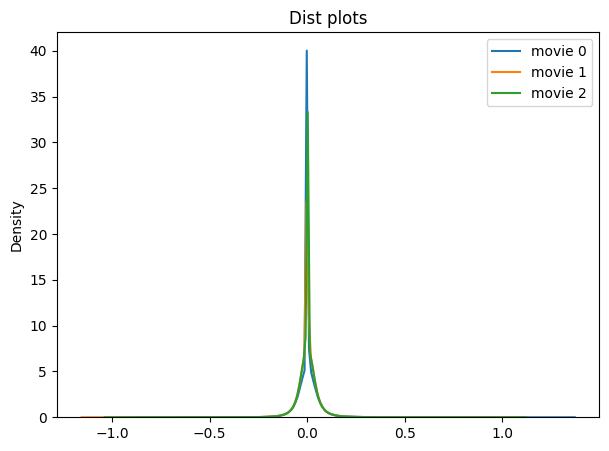

In [32]:
#Normal Distributions of 3 node types after fitting Gaussian Mixture Models 
plot_dist(new_features_dict['movie0'],new_features_dict['movie1'],new_features_dict['movie2'])

In [33]:
#Movie

In [34]:
discrete_class0 = pd.DataFrame(new_features_dict['movie0']).applymap(lambda x: 0.0 if x<0.5 else 1.0 if 0.5>=x<0.6 
                       else 2.0 if 0.6>=x<0.7 else 3.0 if 0.7>=x<0.8 else 4.0 if 0.8>=x<0.9 
                       else 5.0 if 0.9>=x<0.99 else 1.0)

In [35]:
movieclass0_sampled = discrete_class0
movieclass0_sampled['class'] = 0
movieclass0_sampled.shape

(242, 3067)

In [36]:
np.unique(movieclass0_sampled)

array([0., 1., 2., 3., 4., 5.])

In [37]:
discrete_class1 = pd.DataFrame(new_features_dict['movie1']).applymap(lambda x: 0.0 if x<0.5 else 1.0 if 0.5>=x<0.6 
                       else 2.0 if 0.6>=x<0.7 else 3.0 if 0.7>=x<0.8 else 4.0 if 0.8>=x<0.9 
                       else 5.0 if 0.9>=x<0.99 else 1.0)

In [38]:
movieclass1_sampled = discrete_class1
movieclass1_sampled['class'] = 1
movieclass1_sampled.shape

(242, 3067)

In [39]:
np.unique(movieclass1_sampled)

array([0., 1., 2., 3., 4., 5.])

In [40]:
discrete_class2 = pd.DataFrame(new_features_dict['movie1']).applymap(lambda x: 0.0 if x<0.5 else 1.0 if 0.5>=x<0.6 
                       else 2.0 if 0.6>=x<0.7 else 3.0 if 0.7>=x<0.8 else 4.0 if 0.8>=x<0.9 
                       else 1.0)

In [41]:
movieclass2_sampled = discrete_class2
movieclass2_sampled['class'] = 2
movieclass2_sampled.shape

(242, 3067)

In [42]:
np.unique(movieclass2_sampled)

array([0., 1., 2., 3., 4.])

In [43]:
movie_node_features = pd.concat([movieclass0_sampled,movieclass1_sampled,movieclass2_sampled],
                                  ignore_index=True)

In [44]:
class1_node_subset = dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 2)
movie_nodeids = [int(x) for x in list(class1_node_subset.keys())]
movie_node_features.insert(0,'nodeId',movie_nodeids)

In [45]:
movie_node_features

,nodeId,0,1,2,3,4,5,6,7,8,...,3057,3058,3059,3060,3061,3062,3063,3064,3065,class
0,904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,1625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
722,1626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
723,1627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
724,1628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [46]:
#Director

In [47]:
director_node_features = pd.DataFrame(new_features_dict['director'])

In [48]:
class0_node_subset = dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 0)
director_nodeids = [int(x) for x in list(class0_node_subset.keys())]
director_node_features.insert(0,'nodeId',director_nodeids)
director_node_features

,nodeId,0,1,2,3,4,5,6,7,8,...,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065
0,0,-0.002757,0.010164,0.004311,0.021305,0.012218,-0.004178,-0.000550,0.010926,0.022066,...,0.029515,0.047245,-0.035171,0.006468,0.004715,0.009566,-0.000127,-0.068221,-0.004673,0.000961
1,1,0.000646,0.032546,0.001790,0.000159,-0.008500,-0.007204,0.036091,0.006662,-0.025765,...,-0.025080,0.017411,-0.053434,-0.007109,0.031613,0.012382,-0.006661,0.158823,-0.007727,0.012324
2,2,0.002747,-0.009850,0.006146,-0.034355,-0.004675,-0.003730,0.056604,0.009550,0.000445,...,-0.030213,-0.018492,0.079992,-0.027186,0.001716,0.023125,-0.010779,0.081318,0.000433,-0.004134
3,3,-0.008641,-0.003442,-0.007116,0.002731,-0.004164,0.003143,-0.003982,-0.015915,0.028118,...,-0.025814,0.027104,0.029521,0.019057,0.012483,-0.006204,-0.008701,0.050697,-0.002225,-0.003476
4,4,-0.006309,0.009009,0.002194,0.020353,-0.008426,0.002059,0.023186,-0.031230,-0.012676,...,0.023442,-0.032922,0.071591,0.003239,0.014411,-0.010064,0.003498,0.031607,-0.004503,-0.003762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,405,0.003125,0.011696,-0.010214,0.009713,-0.012938,-0.001941,0.005991,-0.008482,-0.001089,...,-0.004833,0.038983,0.061414,0.008581,-0.045114,0.011286,0.006172,0.101729,-0.003784,-0.005680
406,406,-0.005101,0.000296,0.003185,0.000662,0.009546,-0.008942,-0.021314,0.001696,0.037212,...,0.011668,0.056558,0.059255,-0.032762,0.011431,0.008963,0.002739,0.072866,0.014796,-0.004611
407,407,-0.003503,-0.013595,0.017855,-0.012088,0.014189,0.009753,0.011584,0.022799,0.023870,...,-0.013700,0.048322,0.006669,-0.055296,0.004826,-0.002276,0.015490,0.128590,0.017327,0.005941
408,408,-0.004222,-0.024856,-0.019997,0.024921,0.015337,0.010159,0.005917,0.013338,0.069113,...,-0.003104,0.018944,-0.034428,0.023625,-0.056149,0.003778,0.001474,0.151136,0.013224,-0.000986


In [49]:
#Actor

In [50]:
actor_node_features = pd.DataFrame(new_features_dict['actor'])

In [51]:
class1_node_subset = dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 1)
actor_nodeids = [int(x) for x in list(class1_node_subset.keys())]
actor_node_features.insert(0,'nodeId',actor_nodeids)
actor_node_features

,nodeId,0,1,2,3,4,5,6,7,8,...,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065
0,410,-0.019738,0.007037,-0.041063,0.006349,0.003781,0.019081,-0.003313,-0.028191,-0.022735,...,0.017451,0.012501,0.002659,-0.013747,0.005679,-0.007995,-0.016807,-0.155896,0.000859,-0.009668
1,411,0.018394,-0.001308,0.021021,-0.012638,0.003726,0.058079,0.003104,-0.014543,-0.037013,...,0.026826,0.018168,-0.014468,-0.003089,0.009954,0.001247,0.004262,-0.093691,-0.005971,-0.051190
2,412,-0.022016,-0.050614,0.006466,-0.018942,-0.027440,0.014319,-0.008862,0.011928,-0.037594,...,-0.001115,-0.025491,-0.017222,-0.014849,0.011751,-0.057410,0.000268,0.248265,0.002084,0.008547
3,413,-0.008323,-0.043686,-0.008492,0.024046,0.008840,-0.038919,0.020235,-0.010637,0.047453,...,-0.027786,-0.015502,0.040001,0.020890,-0.015281,0.022724,0.001897,0.052227,-0.010454,0.023096
4,414,-0.027655,-0.012687,-0.016675,0.003558,-0.025939,-0.029911,0.029165,0.015828,-0.045303,...,0.026916,-0.045314,-0.015953,-0.007184,0.056829,0.013309,-0.007946,-0.007178,0.007356,0.004151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,899,0.017183,0.014477,0.037979,0.002966,-0.000252,0.007878,0.016880,-0.019032,-0.002736,...,0.056764,0.041122,-0.064509,0.017776,-0.011553,-0.003436,0.001723,-0.008801,0.006458,-0.010539
490,900,0.018623,-0.002689,0.038173,-0.003963,0.015681,0.001209,-0.018090,-0.014866,0.037133,...,0.018312,-0.047826,0.054372,0.005889,-0.010637,-0.036860,0.006744,-0.095448,-0.001128,-0.023428
491,901,-0.004427,-0.030063,-0.015609,-0.018527,-0.001776,-0.013350,-0.005433,-0.010728,0.036408,...,-0.014758,0.025545,0.009672,-0.054168,-0.033361,0.063865,0.026967,0.139740,-0.002615,0.010742
492,902,0.007949,0.029290,0.009006,0.003624,0.005753,0.010977,0.015160,0.036298,0.000400,...,0.002577,0.033591,0.019959,-0.023718,-0.013187,0.030934,0.010292,0.208463,-0.000241,0.013926
